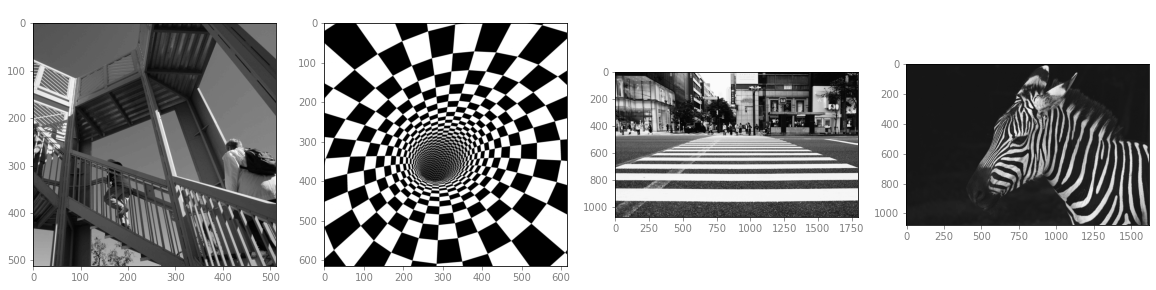

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.misc import ascent

dark_bg = True # Used to adjust matplotlib colors for dark backgrounds
# <editor-fold desc="Matplotlib config" defaultstate="collapsed">
plt.rcParams["image.cmap"] = "gray"
if dark_bg:
    plt.rcParams["text.color"] = "white"
plt.rcParams["xtick.color"] = "gray"
plt.rcParams["ytick.color"] = "gray"
# </editor-fold>

# <editor-fold desc="Load images" defaultstate="collapsed">
def gray_scale(im):
    return np.dot(im, [0.07, 0.72, 0.21]) # grayscale weighted by human color perception

images = [ { "image": ascent(), "name": "ascent" } ]

for image_path in os.listdir("img"):
    image = Image.open(os.path.join("img", image_path), "r")
    if len(np.shape(image)) == 3:
        image = gray_scale(image)

    images.append({ "image": image, "name": os.path.splitext(os.path.basename(image_path))[0] })

_, ax = plt.subplots(ncols=len(images), figsize=(20, 5))
# </editor-fold>

for i, im in enumerate(images):
    ax[i].set_title(im["name"])
    ax[i].imshow(im["image"])

## Apply Fourier Transformations

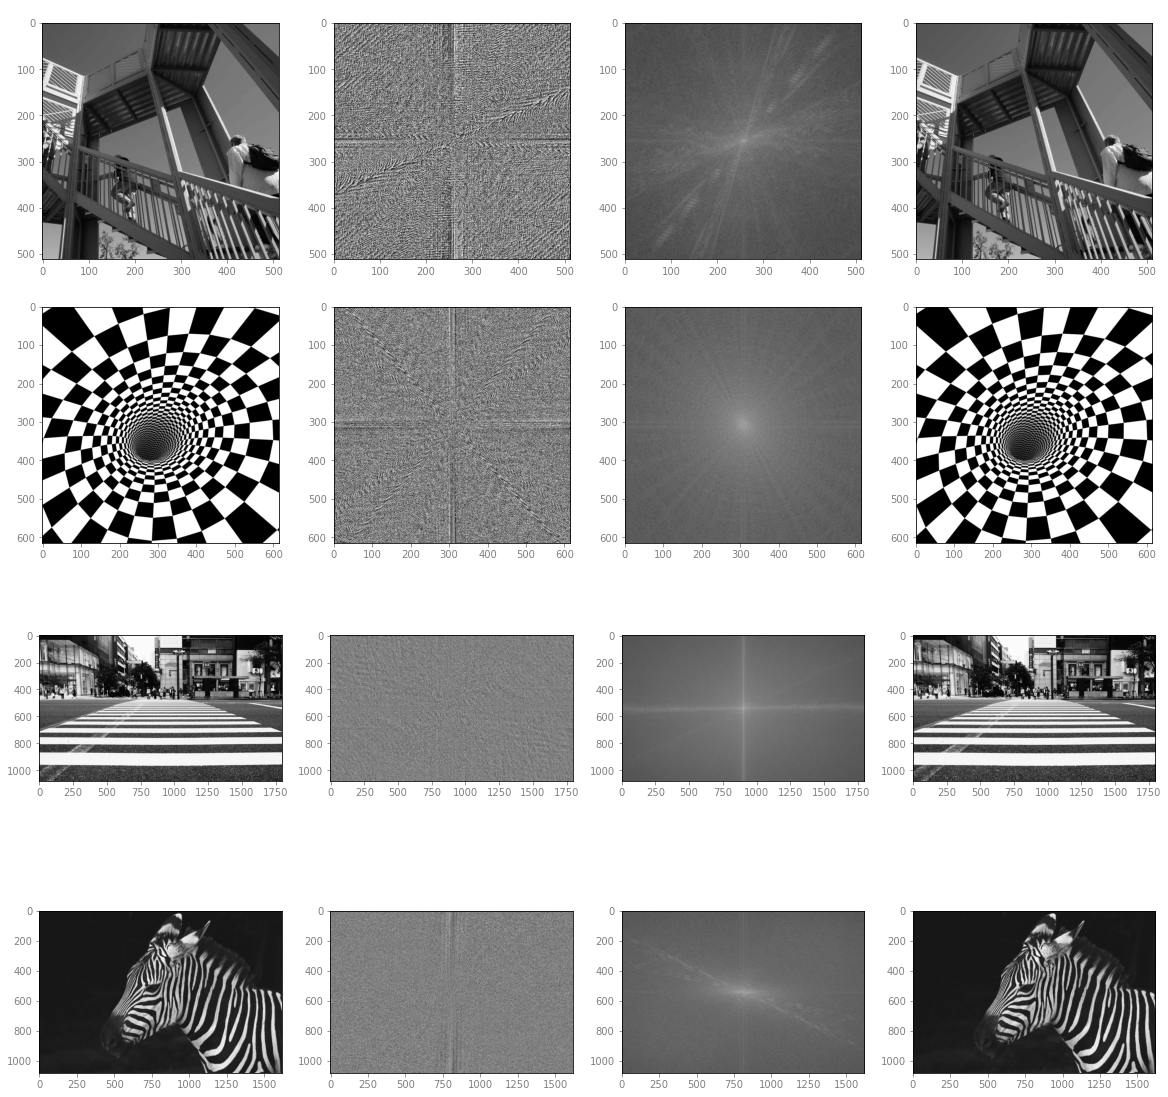

In [6]:
from numpy.fft import fft2, fftshift, ifft2
from os import makedirs

_, ax = plt.subplots(ncols=4, nrows=len(images), figsize=(20, 5 * len(images)))

def log_spectrum(im): # Calculates the logarithmic spectrum from Fourier Space
    return np.log10(1 + np.abs(im) ** 2)

def ilog_spectrum(im, im_angle): # Reverts the logarithmic spectrum back to FS
    im_abs = np.sqrt(10 ** im - 1)
    return im_abs * np.cos(im_angle) + im_abs * np.sin(im_angle) * 1j

for i, im in enumerate(images):
    im["fourier"] = (im_fourier := fftshift(fft2(im["image"])))
    im["fourier_angle"] = np.angle(im_fourier)
    im["fourier_log_spec"] = (im_log_spec := log_spectrum(im_fourier))

    ax[i][0].set_title(f"Original image \"{im['name']}\"")
    ax[i][0].imshow(im["image"], vmin=0, vmax=255)
    ax[i][1].set_title("Angle part of FT")
    ax[i][1].imshow(np.angle(im_fourier))
    ax[i][2].set_title("Logarithmic spectrum of FT")
    ax[i][2].imshow(im_log_spec, vmin=0, vmax=20)
    ax[i][3].set_title("FT reverted")
    ax[i][3].imshow(abs(ifft2(ilog_spectrum(im_log_spec, im["fourier_angle"]))), vmin=0, vmax=255)

## Export logarithmic spectrums

In [4]:
export_scale = 20.0 # Should be higher than the spectrum max
for im in images:
    makedirs("spectrum", exist_ok=True)
    plt.imsave(f"spectrum/{im['name']}.png", im["fourier_log_spec"] / export_scale * 255.0, vmin=0, vmax=255)

## Reimport logarithmic spectrums and display

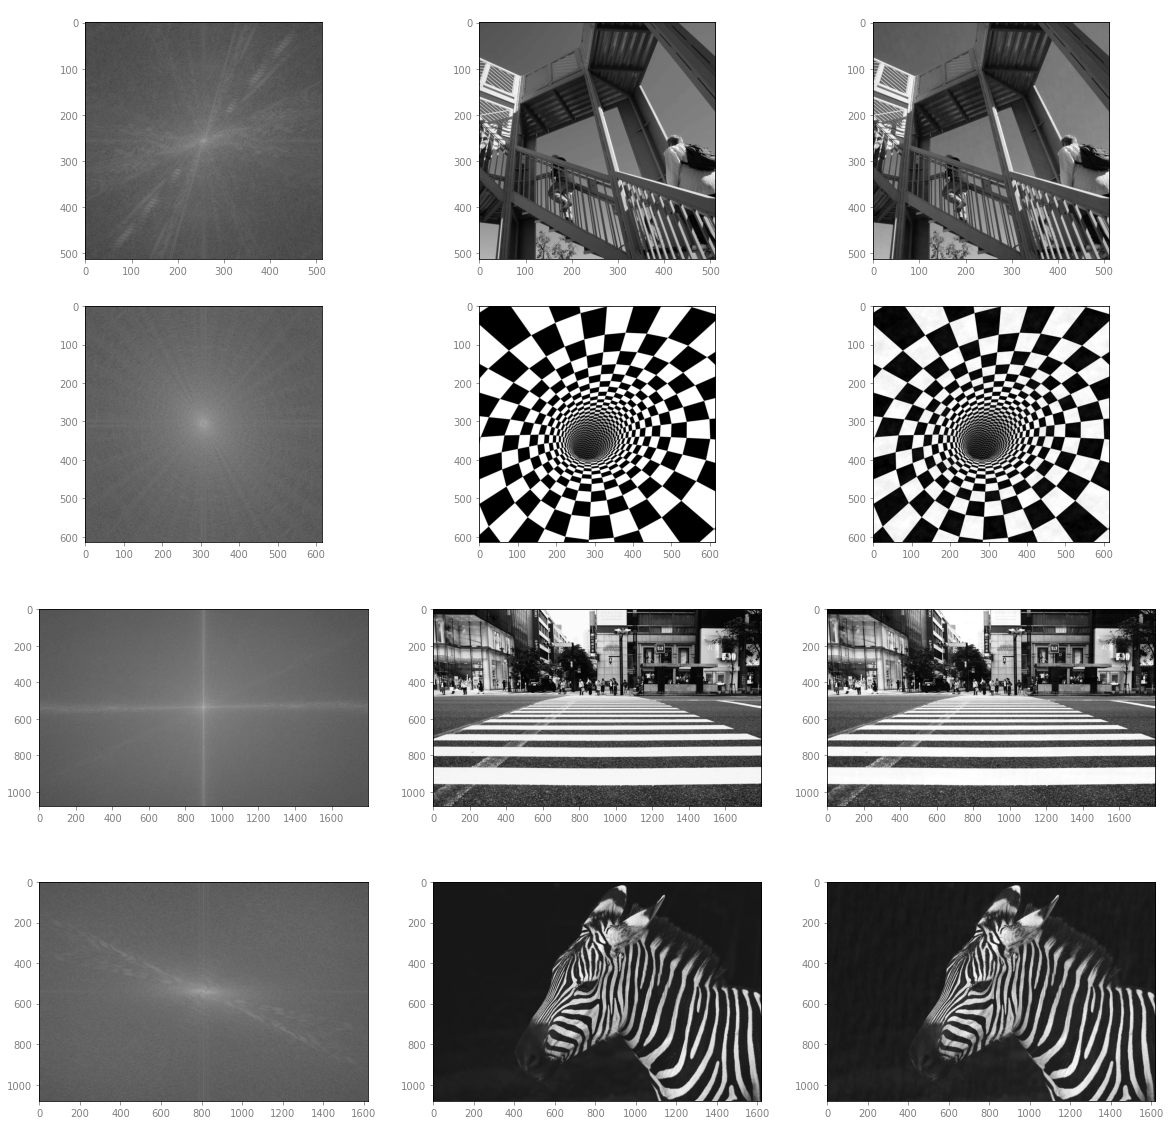

In [5]:
export_scale = 20.0
_, ax = plt.subplots(ncols=3, nrows=len(images), figsize=(20, 5*len(images)))

for i, im in enumerate(images):
    reimport_spec_im = plt.imread(f"spectrum/{im['name']}.png")
    reimport_spec = np.zeros((im["image"].shape[0], im["image"].shape[1])) # required because of different color channels
    if len(reimport_spec_im.shape) == 3: # if image is written with multiple color channels, we need to reduce it to one
        reimport_spec[:,:] = reimport_spec_im[:,:,0]

    reimport_spec = reimport_spec * export_scale # image is already loaded normalized to one so no need to divide through 255
    reimport_fourier = ilog_spectrum(reimport_spec, im["fourier_angle"])
    ax[i][0].set_title("Loaded FT spectrum")
    ax[i][0].imshow(reimport_spec, vmin=0, vmax=20)
    ax[i][1].set_title(f"Original image \"{im['name']}\"")
    ax[i][1].imshow(im["image"], vmin=0, vmax=255)
    ax[i][2].set_title("Modified and reimported image")
    ax[i][2].imshow(abs(ifft2(reimport_fourier)), vmin=0, vmax=255)